# Using storage information to model Henry Hub Gas prices

::: {.callout-note}
Generative AI was used to fix grammar in the writing. The rest is done by me.
:::

In the previous post I built a latent volatility model that was used to predict Henry Hub gas prices. While it was a very simple model, it did output meaningful results in the end. One of the fundamental problems with that kind of model is that it makes no assumption on the nature of the underlying time series. It could just as easily be modeling sheep populations in New Zealand.. Today I'm making the first step in addressing that by including a fundamental macro indicator - reported levels of gas storage, collected by [US Energy Information Administration](https://www.eia.gov/). I'd recommend anyone to spend like 30 mins on their website - the amount of historical information on energy is amazing and it's a great resource all around. 

The reason I decided to start with storage information is because it is a very strong indicator of the volatility. Depending on weather forecasts, the current levels of storage and other events, volatility goes up and down. For example, in warmer months, NG volatility tends to be lower(unless snow hits Texas), and in colder months when sudden frosts hit, the volatility will increase, as there is more demand for an already depleted commodity. 

## EIA gas report

On a [weekly](https://ir.eia.gov/ngs/ngs.html) basis, EIA [collects](https://ir.eia.gov/ngs/methodology.html) information about gas storage levels. I will use storage level information from the lower 48 states. And while, there are other massive storages on other continents, US, on its own, being a massive energy market provides a valuable insight into future volatility values.

## How to include storage levels

Within the bayesian framework, there are a few ways to include the storage information. First of all, the EIA methodology document states that the parties reporting their storage levels are sampled, meaning that from week to week we do not get reports from the same parties. Plus, while it is unclear how much evidence there is, it would reasonable to assume that there inaccuracies in those reports. With that in mind, my initial idea was to model the storage levels as a variable with noisy observation, and consider it a latent variable that was periodically observed. That would lead to a two-level bayesian model. However, our NG prices dataset is on the daily basis and the storage reports are on the weekly basis, making it unclear how exactly those two should be aligned, in case the storage information is assumed a latent variable.

I then decided to use it as an external regressor and leave the more complicated version for future trials. Additionally, I include storage level derivative into the modelling since I found that it helps to make the model more stable, plus conceptually it also makes sense that information about the speed of storage change and its direction are important.

In [374]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# | exporti

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm
from bayesianfin.data import (
    Derivative,
    FeatureEngineer,
    LogReturn,
    QuantileTransformer,
    Variance,
)
from bayesianfin.simulation import Simulator

In [376]:
# | export
az.style.use("arviz-darkgrid")

## Data loading

Start with loading the daily level gas data

In [402]:
gas_data = (
    pl.read_csv("data/ng_daily.csv", try_parse_dates=True)
    .drop_nulls()
    .tail(3500)
    .rename({"Date": "date", "Price": "price"})
).with_columns(
    ret=pl.col("price") / pl.col("price").shift(1),
)
gas_data

date,price,ret
date,f64,f64
2011-04-01,4.32,null
2011-04-04,4.21,0.974537
2011-04-05,4.22,1.002375
2011-04-06,4.17,0.988152
2011-04-07,4.12,0.98801
…,…,…
2025-02-04,3.25,0.984848
2025-02-05,3.22,0.990769
2025-02-06,3.31,1.02795


I then load storage data, focusing only on the lower 48 states. The relevant column is renamed to storage for convenience.

In [378]:
ng_storage_data = (
    pl.read_csv("data/ng_storage.csv", truncate_ragged_lines=True)
    .with_columns(
        pl.col("Week ending").str.strptime(pl.Datetime, "%d-%b-%y").alias("date"),
    )
    .with_columns(pl.col("date").cast(pl.Date))
    .rename({"Total Lower 48": "storage"})
)
ng_storage_data.head()

Week ending,Source,East Region,Midwest Region Mountain Region,Pacific Region,South Central Region,Salt,NonSalt,storage,date
str,str,i64,i64,i64,i64,i64,i64,i64,date
"""01-Jan-10""","""Derived EIA Weekly Estimates""",769,900,195,268,985,159,826,2010-01-01
"""08-Jan-10""","""Derived EIA Weekly Estimates""",703,820,185,257,886,123,763,2010-01-08
"""15-Jan-10""","""Derived EIA Weekly Estimates""",642,750,176,246,793,91,702,2010-01-15
"""22-Jan-10""","""Derived EIA Weekly Estimates""",616,710,171,235,789,102,687,2010-01-22
"""29-Jan-10""","""Derived EIA Weekly Estimates""",582,661,164,221,779,108,671,2010-01-29


Here is what storage dynamic look like:

<Axes: xlabel='date', ylabel='storage'>

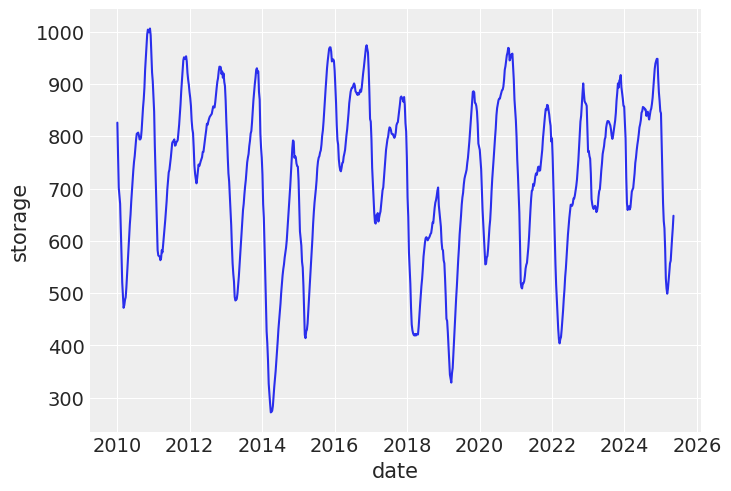

In [415]:
sns.lineplot(ng_storage_data, x="date", y="storage")

Finally, joining both frames into one.

In [380]:
gas_storage_data = gas_data.join(
    ng_storage_data["date", "storage"], how="left", on="date"
).with_columns(pl.col("storage").forward_fill())
gas_storage_data.head()


date,price,ret,storage
date,f64,f64,i64
2011-04-01,4.32,null,578
2011-04-04,4.21,0.974537,578
2011-04-05,4.22,1.002375,578
2011-04-06,4.17,0.988152,578
2011-04-07,4.12,0.98801,578


I use my feature engineer class to extract the following features:

1. Log-return
1. Log-variance
1. Storage and variance quantiles
1. Storage quantile derivative

I use quantiles pretty much everywhere, because it is good way to standardise the data and still leave a lot of useful information in the transformed variable. If the value is 0.99, you know it's a rare event, which is useful for debugging.

In [ ]:
# | exec: false
feature_engineer = FeatureEngineer(
    drop_nulls=False,
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
        Variance(
            source_field="price",
            feature_name="var",
            rolling_variance_window=2,
        ),
        LogReturn(source_field="var", feature_name="log_var", requested_lag=0),
        QuantileTransformer(
            source_field="var", feature_name="var_quantile", requested_lag=1
        ),
        QuantileTransformer(
            source_field="storage",
            feature_name="storage_quantile",
            step_size=8,
            requested_lag=1,
        ),
        Derivative(
            source_field="storage_quantile",
            feature_name="storage_quantile_derivative",
            step_size=8,
            requested_lag=1,
        ),
    ],
    n_shifts=3,
)
df_with_features = feature_engineer.create_features(gas_storage_data)
df_with_features = df_with_features.drop_nulls()
df_with_features

date,price,ret,storage,log_ret,var,log_var,var_quantile,storage_quantile,storage_quantile_derivative,month,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3,prev_var_1,prev_var_2,prev_var_3,prev_var_quantile_1,prev_storage_quantile_1,prev_storage_quantile_derivative_1
date,f64,f64,i64,f64,f64,f64,f64,f64,f64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64
2011-04-26,4.32,0.988558,610,-0.011508,0.00125,-6.684612,0.470952,0.22973,0.027528,3,0.009195,0.0,0.032867,0.0008,0.0001,0.0098,0.411746,0.202202,0.019019
2011-04-27,4.35,1.006944,610,0.00692,0.00045,-7.706263,0.340426,0.22973,0.027528,3,-0.011508,0.009195,0.0,0.00125,0.0008,0.0001,0.470952,0.202202,0.019019
2011-04-28,4.38,1.006897,610,0.006873,0.00045,-7.706263,0.340574,0.22973,0.0,3,0.00692,-0.011508,0.009195,0.00045,0.00125,0.0008,0.340426,0.22973,0.046547
2011-04-29,4.51,1.02968,640,0.029248,0.00845,-4.773589,0.770854,0.264765,0.035035,3,0.006873,0.00692,-0.011508,0.00045,0.00045,0.00125,0.340574,0.22973,0.046547
2011-05-02,4.6,1.019956,640,0.019759,0.00405,-5.509038,0.658659,0.264765,0.035035,4,0.029248,0.006873,0.00692,0.00845,0.00045,0.00045,0.770854,0.22973,0.046547
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-02-04,3.25,0.984848,638,-0.015267,0.00125,-6.684612,0.47869,0.261762,-0.200701,1,0.11892,-0.062831,-0.080043,0.06845,0.01805,0.0338,0.951502,0.462462,-0.115616
2025-02-05,3.22,0.990769,638,-0.009274,0.00045,-7.706263,0.347916,0.261762,-0.074074,1,-0.015267,0.11892,-0.062831,0.00125,0.06845,0.01805,0.47869,0.335836,-0.242242
2025-02-06,3.31,1.02795,638,0.027567,0.00405,-5.509038,0.662417,0.261762,-0.074074,1,-0.009274,-0.015267,0.11892,0.00045,0.00125,0.06845,0.347916,0.335836,-0.242242


In [382]:
# Cut-off point
T = 300
(
    present_value_log_ret,
    present_value_log_var,
    storage,
    month,
    present_value_test,
) = (
    df_with_features["log_ret"][:-T].to_numpy(),
    df_with_features["log_var"][:-T].to_numpy(),
    df_with_features["storage_quantile"][:-T].to_numpy(),
    df_with_features["month"][:-T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[:-T]),
    feature_engineer.to_numpy_dict(df_with_features[-T:]),
)

## Model definition

The model is defined in the same way it was described above.

In [403]:
# | export
def garch_like_sample_vol_model(
    value_log_ret: npt.NDArray = None,
    log_var_value: npt.NDArray = None,
    storage: npt.NDArray = None,
    month: npt.NDArray = None,
    past_values: dict[str, npt.NDArray] = None,
) -> None:
    def_spread = 0.05
    b_var = numpyro.sample("b_var", dist.Normal(0, def_spread))

    coeffs = {}

    for p in ["var_quantile", "storage_quantile", "storage_quantile_derivative"]:
        for col, s in feature_engineer.get_iterator(p):
            param_name = feature_engineer.get_shift_pattern(col, s)
            coeffs[param_name] = numpyro.sample(
                f"param_{param_name}", dist.Normal(-4.5, def_spread)
            )
    len_observations = len(value_log_ret) if value_log_ret is not None else 1
    with numpyro.plate("data", len_observations):
        mu_log_var = b_var
        for p in ["var_quantile", "storage_quantile", "storage_quantile_derivative"]:
            for col, s in feature_engineer.get_iterator(p):
                param_name = feature_engineer.get_shift_pattern(col, s)
                mu_log_var += coeffs[param_name] * past_values[param_name]

        log_var = numpyro.sample(
            "log_var", dist.Normal(mu_log_var, 0.1), obs=log_var_value
        )

        std = jnp.exp(log_var / 2)
        # Condition on observed values if provided
        numpyro.sample("log_ret", dist.Normal(0, std), obs=value_log_ret)


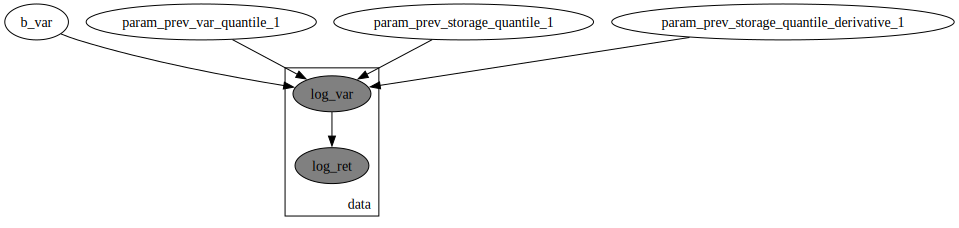

In [405]:
numpyro.render_model(
    garch_like_sample_vol_model,
    model_args=(
        present_value_log_ret,
        present_value_log_var,
        storage,
        month,
        past_values_train,
    ),
)

The first order of business is to do PPC - prior predictive checks. In out case, I deal with data in the temporal domain, hence our checks will be autoregressive too. What I mainly want to check here is that with the current prior I do not get explosive time series, and they stay within a reasonable level. On the image below, you can see, that this is indeed the case.

Though PPCs are very useful in general, practically speaking, if you have a lot of observations, bad prior will be overcome by those data. This is the case for this model too: I tried to set unreasonable priors and the model would converge to the same values again and again. That's because there are thousands of samples. Nonetheless, it is a good practice and I do it.

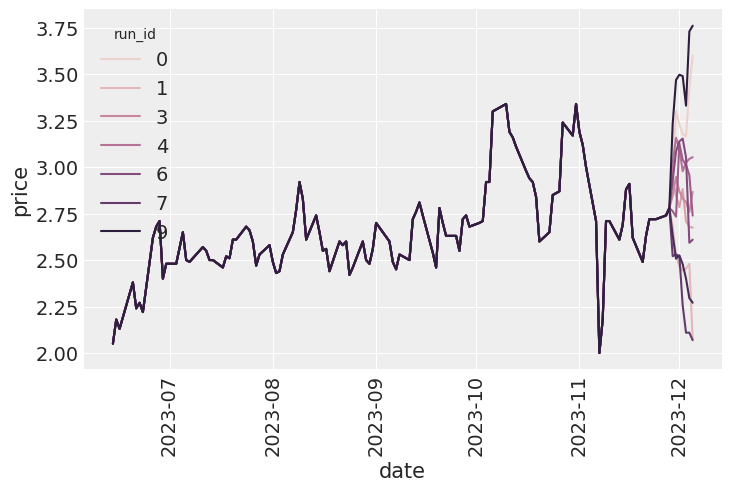

In [404]:
simulator = Simulator(
    model=garch_like_sample_vol_model,
    feature_engineer=feature_engineer,
    exo_fixed_effects=["month"],
    inherit_vals=["storage"],
)
starting_sim_df = gas_storage_data[-T - feature_engineer.n_shifts * 5 - 100 : -T]
all_runs = simulator.simulate_paths(
    steps=7,
    starting_sim_df=starting_sim_df,
    posterior_samples=None,
    num_sims=10,
)

sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);

## Fitting and diagnostics

The model is fitted using MCMC. You can see that estimates are relatively tight.  Note, how the derivative is entering with the negative sign into the linear equation. If the storage level is dropping(negative change), the term will make a positive contribution into the volatility.

I also show the MCMC diagnostics below. There is a decent number of samples with low autocorrelations and the chains look to be mixing well. 

In [385]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_like_sample_vol_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    present_value_log_ret,
    present_value_log_var,
    storage,
    month,
    past_values_train,
)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1742.73it/s, 7 steps of size 2.36e-01. acc. prob=0.93] 


                                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                                     b_var     -7.11      0.00     -7.11     -7.12     -7.10   1296.73      1.00
             param_prev_storage_quantile_1      0.19      0.01      0.19      0.18      0.20   1335.46      1.00
  param_prev_storage_quantile_derivative_1     -3.25      0.02     -3.25     -3.29     -3.21   1161.86      1.00
                 param_prev_var_quantile_1      1.23      0.01      1.23      1.22      1.24   1393.80      1.00

Number of divergences: 0
dict_keys(['b_var', 'param_prev_storage_quantile_1', 'param_prev_storage_quantile_derivative_1', 'param_prev_var_quantile_1'])


/Users/sofeikov/work/bayesianfin/.venv/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['^log_ret_var'] have not been found and will be ignored
  warnings.warn(


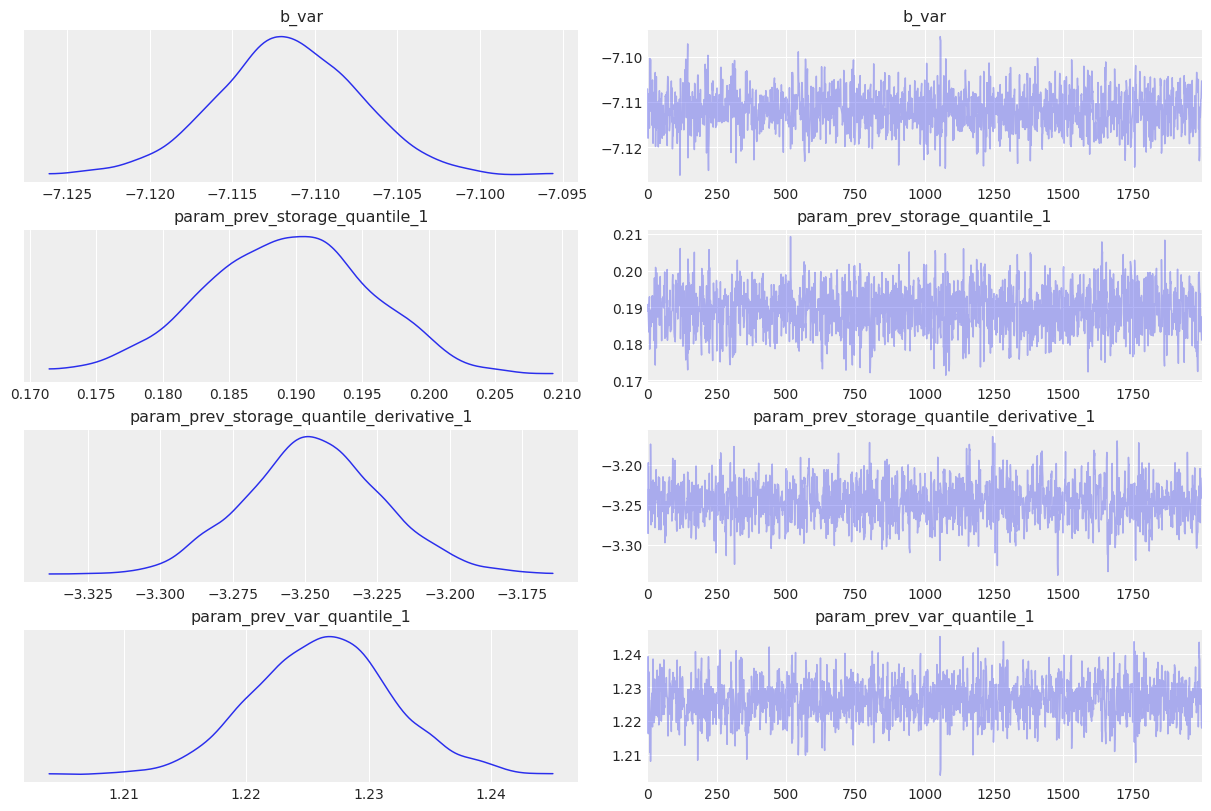

In [406]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(
    garch_like_sample_vol_model,
    posterior_samples=posterior_samples,
    return_sites=["log_ret"],  # or whatever your observation site is called
)
rng_key, rng_key_ppc = random.split(rng_key)
ppc_samples = predictive(
    rng_key_ppc,
    present_value_log_ret,
    present_value_log_var,
    storage,
    month,
    past_values_train,
)
prior_samples = Predictive(garch_like_sample_vol_model, num_samples=2000)(
    rng_key,
    present_value_log_ret,
    present_value_log_var,
    storage,
    month,
    past_values_train,
)

idata = az.from_numpyro(mcmc, posterior_predictive=ppc_samples, prior=prior_samples)
az.plot_trace(idata, var_names=["~^log_ret_var"], filter_vars="regex");

## Autoregressive quality checks

In this section I show how to check the quality of the model in this autoregressive setup. First I model a few dozens paths to see if on average the predictions stays within reasonable bounds. It is followed by inclusion error checks - model a few points in the future, and see where does an actual price lies within your prediction range.

In [413]:
simulator = Simulator(
    model=garch_like_sample_vol_model,
    feature_engineer=feature_engineer,
    exo_fixed_effects=["month"],
    inherit_vals=["storage"],
)
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
starting_sim_df = gas_storage_data[-T - feature_engineer.n_shifts * 5 - 50 : -T]
all_runs = simulator.simulate_paths(
    steps=30,
    starting_sim_df=starting_sim_df,
    posterior_samples=None,
    num_sims=100,
)


As you can see on the image below, the paths look quite reasonable, with few deviating too much. This was, of course, a qualitative statement, rather than a quantitative one. But the latter is coming too.

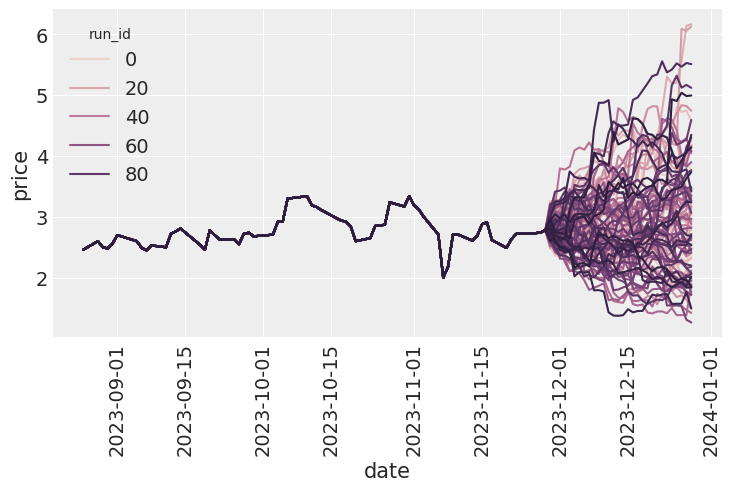

In [414]:
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);

<Axes: xlabel='final_price', ylabel='Count'>

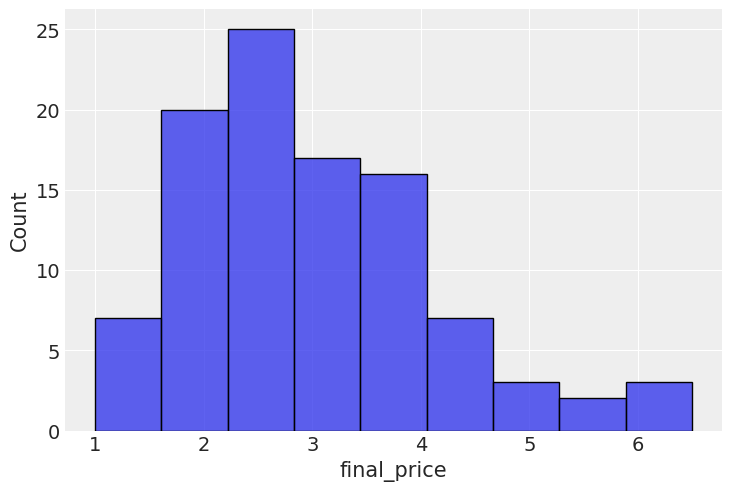

In [411]:
last_prices = (
    all_runs.sort("date")  # Ensure dates are in correct order
    .group_by("run_id")
    .agg(pl.col("price").last())  # Get the last price for each run
    .rename({"price": "final_price"})
)
sns.histplot(last_prices, x="final_price")

## Inclusion error checks

Here I do some inclusion checks to see how well the actual prices fit into the price spread predicted by the model. 

In [ ]:
target_window = 7
posterior_for_gen = {k: ps[0:1] for k, ps in posterior_samples.items()}
shifts = list(range(0, T, 10))
all_lasts = []
actual_prices = []
for ct, t in tqdm(enumerate(shifts), total=len(shifts)):
    starting_sim_df = gas_storage_data[
        -T - feature_engineer.n_shifts * 5 - 50 + t : -T + t
    ]
    this_sim = simulator.simulate_paths(
        steps=target_window,
        starting_sim_df=starting_sim_df,
        posterior_samples=posterior_for_gen,
        num_sims=50,
    )
    last_prices = (
        this_sim.sort("date")  # Ensure dates are in correct order
        .group_by("run_id")
        .agg(pl.col("price").last())  # Get the last price for each run
        .rename({"price": "final_price"})
        .with_columns(pl.lit(ct).alias("run_id"))
    )
    actual_prices.append(
        {"run_id": ct, "actual_price": gas_storage_data[-T + t]["price"][0]}
    )
    all_lasts.append(last_prices)
all_lasts = pl.concat(all_lasts)
actual_prices = pl.DataFrame(actual_prices)

100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


From the image below it can be seen that all observed prices, except for one(which was a huge jump in real data) lie within the predicted interval. However it is always interesting to compare it with another version of the model. Let's do that for the model that does not include storage as a regressor. Here is the result:

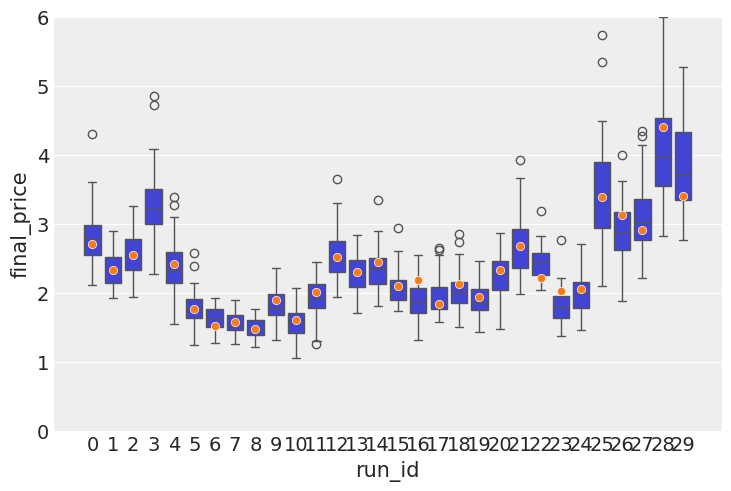

If you compare this image with the image below, you can clearly see that there are less outliers in the box plot, which means that the storage information that I added lead to improved precision and prediction stability. Which means that the storage information does indeed contain a useful signal. Practically speaking, if you model does not overprice the commodity value too much, it means that you can offer more competitive prices on the derivatives you might be selling.

(0.0, 6.0)

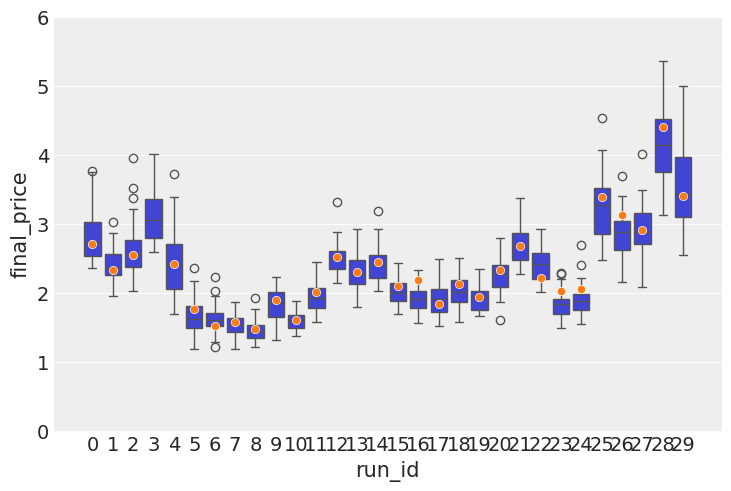

In [ ]:
sns.boxplot(data=all_lasts, x="run_id", y="final_price")
sns.scatterplot(data=actual_prices, x="run_id", y="actual_price", zorder=10)

The observed tighter spread above is confirmed by a lower error(0.065 vs 0.087).

In [412]:
all_lasts.join(
    actual_prices, left_on="run_id", right_on="run_id", how="inner"
).with_columns(error=(pl.col("final_price") - pl.col("actual_price")) ** 2).group_by(
    "run_id"
).agg(pl.col("error").mean())["error"].median()

0.06586484831089998

## Conclusion

By including storage information as regressors I was able to get a better model that has a better predictive power and more realistic volatility dynamics. By finally using macro regressors like storage levels, I finally get to work on a model that is somewhat unique to gas and it can reflect that market's specific dynamics. 

Despite improving precision, this model suffers still suffers from the following:

1. The vol window is too short in the feature engineering
1. The volatility-of-volatility is currently fixed at a very low number. So far I could not find a satisfactory way to model it, it just leads to volatility explosion
1. The seasonal effects are not included. Given that on winter months storages are depleted, while being injected in the summer, this should explain a good deal of volatility. However, this introduces 12 additional parameters and it is unclear how use them. As a bias entry into volatility? As a vol-of-vol? As something affecting the storage levels? 

So far adding seasonality effects has led to worse sampling efficiency in the MCMC, and while prediction still look good, they do not improve, which feels wrong. Stay tuned — tackling seasonality is my next move.

## Additional reading
* [Understanding Henry Hub](https://www.cmegroup.com/education/courses/introduction-to-energy/introduction-to-natural-gas/understanding-henry-hub.html)
* [Natural gas seasonality and storage](https://www.cmegroup.com/education/courses/introduction-to-energy/introduction-to-natural-gas/understanding-natural-gas-risk-management-spreads-storage.html)
* [Weekly gas storage report](https://ir.eia.gov/ngs/ngs.html)